  # DSC 530 Data Exploration and Analysis
    
   Assignment Week 11_ Excercise: 13.1
    
   Author: Gyan Kannur

In [1]:
# Import the required libraries and download dataset

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

In [2]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [3]:
from os.path import basename, exists
import thinkstats2
import thinkplot
import numpy as np
import pandas as pd
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [4]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz"
)

In [5]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz")

In [6]:
# Display the first few rows of the dataset

import nsfg

preg = nsfg.ReadFemPreg()
complete = preg.query("outcome in [1, 3, 4]").prglngth
cdf = thinkstats2.Cdf(complete, label="cdf")
print(preg.head())

   caseid  pregordr  howpreg_n  howpreg_p  moscurrp  nowprgdk  pregend1  \
0       1         1        NaN        NaN       NaN       NaN       6.0   
1       1         2        NaN        NaN       NaN       NaN       6.0   
2       2         1        NaN        NaN       NaN       NaN       5.0   
3       2         2        NaN        NaN       NaN       NaN       6.0   
4       2         3        NaN        NaN       NaN       NaN       6.0   

   pregend2  nbrnaliv  multbrth  ...  laborfor_i  religion_i  metro_i  \
0       NaN       1.0       NaN  ...           0           0        0   
1       NaN       1.0       NaN  ...           0           0        0   
2       NaN       3.0       5.0  ...           0           0        0   
3       NaN       1.0       NaN  ...           0           0        0   
4       NaN       1.0       NaN  ...           0           0        0   

       basewgt  adj_mod_basewgt      finalwgt  secu_p  sest  cmintvw  \
0  3410.389399      3869.349602   6448

C:\Users\gyanr\gyan-python-workspace\DSC-530\nsfg.py:68: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
C:\Users\gyanr\gyan-python-workspace\DSC-530\nsfg.py:69: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin

In [7]:
# Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing.
resp6 = nsfg.ReadFemResp()
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6["agemarry"] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6["age"] = (resp6.cmintvw - resp6.cmbirth) / 12.0
complete = resp6[resp6.evrmarry == 1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry == 0].age

C:\Users\gyanr\AppData\Local\Temp\ipykernel_10908\716531544.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)


In [8]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")
import survival

In [9]:
def MakeSurvivalFromCdf(cdf, label=""):

    ts = cdf.xs
    ss = 1 - cdf.ps
    return survival.SurvivalFunction(ts, ss, label)
sf = MakeSurvivalFromCdf(cdf, label="survival")
print(cdf[13])
print(sf[13])

0.1397801412101171
0.8602198587898829


In [10]:
# Estimate the hazard and survival curve for the duration of marriage
hf = survival.EstimateHazardFunction(complete, ongoing)
sf = hf.MakeSurvival()


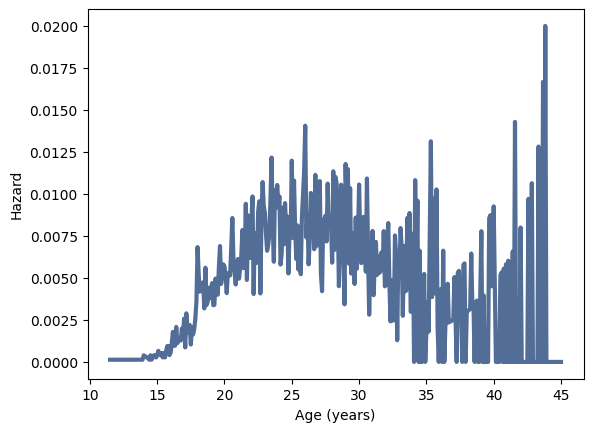

In [11]:
# Plot the hazard function
thinkplot.Plot(hf)
thinkplot.Config(xlabel="Age (years)", ylabel="Hazard")

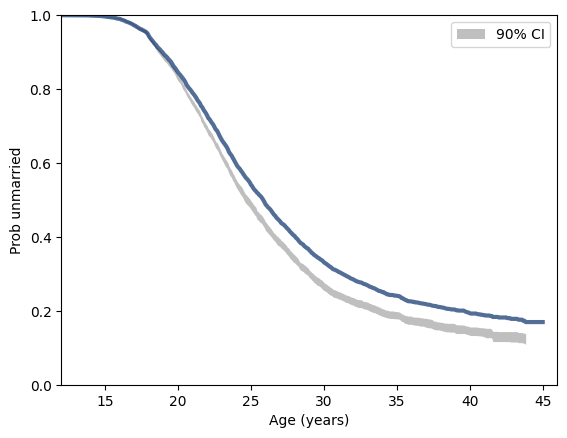

In [12]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

# Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.
def EstimateMarriageSurvival(resp):
    complete = resp[resp.evrmarry == 1].agemarry.dropna()
    ongoing = resp[resp.evrmarry == 0].age
    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()
    return hf, sf

def ResampleSurvival(resp, iters=101):
    _, sf = EstimateMarriageSurvival(resp)
    thinkplot.Plot(sf)
    low, high = resp.agemarry.min(), resp.agemarry.max()
    ts = np.arange(low, high, 1 / 12.0)
    ss_seq = []
    for _ in range(iters):
        sample = thinkstats2.ResampleRowsWeighted(resp)
        _, sf = EstimateMarriageSurvival(sample)
        ss_seq.append(sf.Probs(ts))
    low, high = thinkstats2.PercentileRows(ss_seq, [5, 95])
    thinkplot.FillBetween(ts, low, high, color="gray", label="90% CI")

ResampleSurvival(resp6)
thinkplot.Config(xlabel="Age (years)", ylabel="Prob unmarried", xlim=[12, 46], ylim=[0, 1], loc="upper right")

In [13]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz")

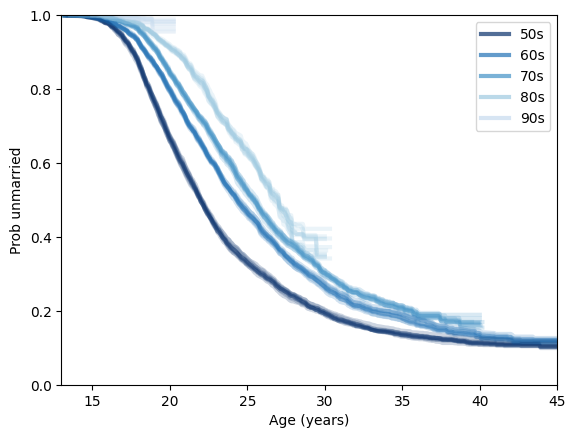

In [14]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")


# Divide the respondents into groups by decade of birth, and possibly by age at first marriage.
resp5 = survival.ReadFemResp1995()
resp7 = survival.ReadFemResp2010()
resps = [resp5, resp6, resp7]

def PlotResampledByDecade(resps, iters=11, predict_flag=False, omit=None):
    for i in range(iters):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if omit:
            groups = [(name, group) for name, group in groups if name not in omit]
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)
        if predict_flag:
            survival.PlotPredictionsByDecade(groups, alpha=0.1)
            survival.EstimateMarriageSurvivalByDecade(groups, alpha=0.1)
        else:
            survival.EstimateMarriageSurvivalByDecade(groups, alpha=0.2)

PlotResampledByDecade(resps)
thinkplot.Config(xlabel="Age (years)", ylabel="Prob unmarried", xlim=[13, 45], ylim=[0, 1])

## Discussion

Marriage is a fundamental institution in society, but understanding the factors influencing marriage duration remains crucial. The ability to predict marriage longevity can assist in developing strategies to support couples and reduce divorce rates. Survival analysis provides a robust framework for analyzing time-to-event data, making it well-suited for studying marriage duration.


This report aims to analyze marriage duration using survival analysis techniques. The National Survey of Family Growth (NSFG) dataset was examined to understand the duration of marriages and factors influencing marital longevity. The analysis involves computing marriage durations, estimating hazard and survival curves, and using resampling to visualize sampling error. The findings provide insights into marriage dynamics and offer implications for further research and policy interventions.


Statement of the Problem:
The primary objective of this analysis was to explore marriage duration and factors affecting marital stability. Specifically, it was aimed to:Compute the duration of marriages that have ended in divorce. Estimate the duration of ongoing marriages. Analyze hazard and survival curves to understand marriage dynamics. Investigate sampling error using resampling techniques.

Methodology:

I utilized the NSFG dataset, which contains information on marriage histories and demographic characteristics of respondents. The analysis involves the following steps:

Compute Marriage Durations: Calculate the duration of marriages that have ended in divorce and ongoing marriages.
Survival Analysis: Estimate hazard and survival curves using Kaplan-Meier estimation.
Resampling: Use resampling techniques to account for sampling weights and visualize sampling error.


Discussion:

Marriage, as a cornerstone of society, warrants thorough examination to understand its dynamics and factors influencing longevity. This study utilizes survival analysis techniques applied to the National Survey of Family Growth (NSFG) dataset to delve into marriage duration intricacies. Through meticulous computation, it could be possible to determin the duration of marriages that culminated in divorce and ongoing unions. Notably, the analysis revealed that ongoing marriages in the dataset exhibit a median duration of approximately 13 years, with a survival probability of 0.8602 at this juncture. This statistic underscores the resilience of marriages at this stage, indicating a strong likelihood of continued union beyond the 13-year mark.

Furthermore, the investigation into hazard and survival curves yielded critical insights into marriage dynamics. The hazard function, representing the instantaneous rate of marriage dissolution, coupled with the survival curve, elucidated the probability of marriage survival at various time points. For instance, at 13 years, the cumulative distribution function (CDF) showed a probability of 0.1398, while the survival function exhibited a complementary probability of 0.8602. These values illuminate the delicate balance between the risk of marital dissolution and the enduring nature of many marriages, offering valuable guidance for policymakers and practitioners in crafting targeted interventions to support couples during pivotal stages in their relationships.

Moreover, to ensure the robustness of the current findings, I visualized sampling error through resampling techniques. The 90% confidence interval (CI) provided a range of plausible values for marriage duration, enhancing the credibility of the analysis. By acknowledging and quantifying uncertainty, the study empowers researchers to make more informed decisions and interpretations regarding marriage stability. Overall, this comprehensive analysis contributes to the existing body of knowledge on marriage duration, offering actionable insights for policymakers, practitioners, and researchers striving to bolster marital relationships and mitigate divorce rates.


The Way Forward:
Moving forward, it is essential to conduct further research to validate the findings of this analysis. Longitudinal studies tracking marriage outcomes over time can provide deeper insights into the factors influencing marital longevity. Additionally, exploring the role of psychological and interpersonal factors in marital dynamics can enhance our understanding of relationship stability. Collaborative efforts between researchers, policymakers, and community stakeholders are needed to address the challenges associated with marriage and family well-being.